In [1]:
# code imported from Susan Li, with some minor tweaks to fit my scenario:
# https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/LSTM%20Time%20Series%20Power%20Consumption.ipynb 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
%autosave 180

Autosaving every 180 seconds


In [2]:
eth_data = pd.read_csv("eth_usd.csv")

In [3]:
eth_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.6450,329.4520,307.0560,320.8840,320.8840,893249984
1,2017-11-10,320.6710,324.7180,294.5420,299.2530,299.2530,885985984
2,2017-11-11,298.5860,319.4530,298.1920,314.6810,314.6810,842300992
3,2017-11-12,314.6900,319.1530,298.5130,307.9080,307.9080,1613479936
4,2017-11-13,307.0250,328.4150,307.0250,316.7160,316.7160,1041889984


In [4]:
# Convert High to numeric and remove missing values 

In [5]:
eth_data['High'] = pd.to_numeric(eth_data['High'], errors='coerce')
eth_data = eth_data.dropna(subset=['High'])

In [6]:
# Create year, quarter, month and day features

In [7]:
eth_data['date'] = pd.to_datetime(eth_data['Date'])
eth_data['year'] = eth_data['date'].apply(lambda x: x.year)
eth_data['quarter'] = eth_data['date'].apply(lambda x: x.quarter)
eth_data['month'] = eth_data['date'].apply(lambda x: x.month)
eth_data['day'] = eth_data['date'].apply(lambda x: x.day)
eth_data = eth_data.loc[:,['date','High', 'year','quarter','month','day']]
eth_data.sort_values('date', inplace=True, ascending=True)
eth_data = eth_data.reset_index(drop=True)

In [8]:
# Calculate Kurtosis and Skewness, to determine if the data distribution departs from the Gaussian/Normal Distribution

In [9]:
stat, p = stats.normaltest(eth_data.High)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=318.060, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 0.5878008578484262
Skewness of normal distribution: 1.3826260847456937


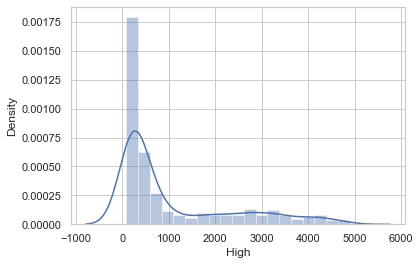

In [10]:
sns.distplot(eth_data.High);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(eth_data.High)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(eth_data.High))) 

In [11]:
# Plot Mean High Opening Price Grouped by Year, Quarter, Month and Day

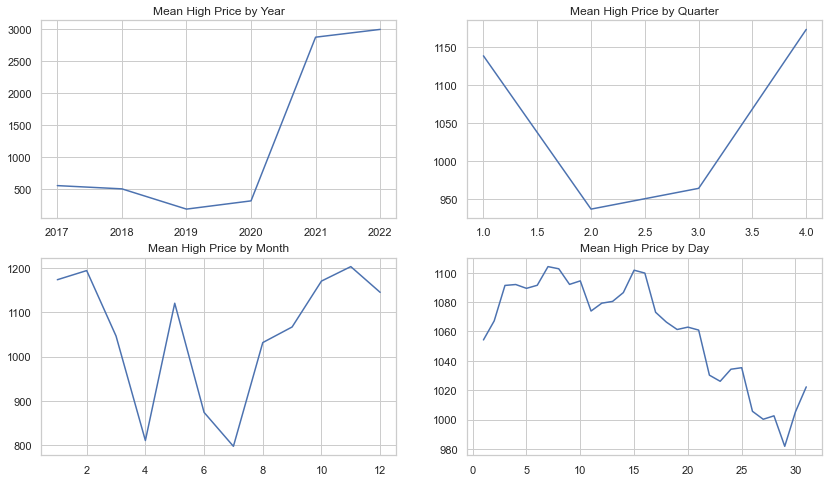

In [12]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
eth_data.groupby('year').High.agg('mean').plot()
plt.xlabel('')
plt.title('Mean High Price by Year')

plt.subplot(2,2,2)
eth_data.groupby('quarter').High.agg('mean').plot()
plt.xlabel('')
plt.title('Mean High Price by Quarter')

plt.subplot(2,2,3)
eth_data.groupby('month').High.agg('mean').plot()
plt.xlabel('')
plt.title('Mean High Price by Month')

plt.subplot(2,2,4)
eth_data.groupby('day').High.agg('mean').plot()
plt.xlabel('')
plt.title('Mean High Price by Day');

In [13]:
# Lowest Price by
# Year: 2019
# Quarter: 2nd
# Month: April
# Day: 29th

In [14]:
# Normalize features and split into Training + Test sets

In [15]:
dataset = eth_data.High.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [16]:
# Fit model for 20 training epochs with a batch size of 80

In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=80, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
16/16 [==============================] - 3s 44ms/step - loss: 0.0055 - val_loss: 0.0225
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0445
Epoch 3/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0081
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 8.1713e-04 - val_loss: 0.0389
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 9.4812e-04 - val_loss: 0.0223
Epoch 6/20
16/16 [==============================] - 0s 6ms/step - loss: 7.9199e-04 - val_loss: 0.0301
Epoch 7/20
16/16 [==============================] - 0s 6ms/step - loss: 7.9064e-04 - val_loss: 0.0245
Epoch 8/20
16/16 [==============================] - 0s 6ms/step - loss: 7.5534e-04 - val_loss: 0.0330
Epoch 9/20
16/16 [==============================] - 0s 7ms/step - loss: 7.2612e-04 - val_loss: 0.0251
Epoch 10/20
16/16 [==============================] - 0s 6ms/step - loss: 6.7059e-04 - val_los

In [18]:
# Make predictions

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

10/10 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 67.0665083281694
Train Root Mean Squared Error: 114.62364169822489
Test Mean Absolute Error: 948.6722044022008
Test Root Mean Squared Error: 1059.4635825256116


In [20]:
# Model Loss

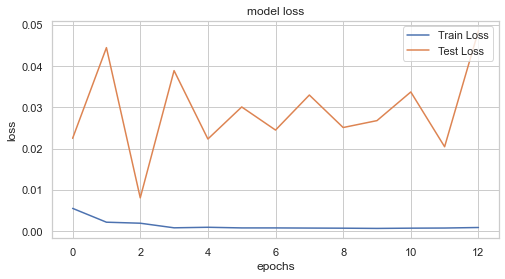

In [21]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [22]:
# Definitely shows the kind of volatility that Crypto has!

In [23]:
# Compare Actual vs Predictions over past 3 hours

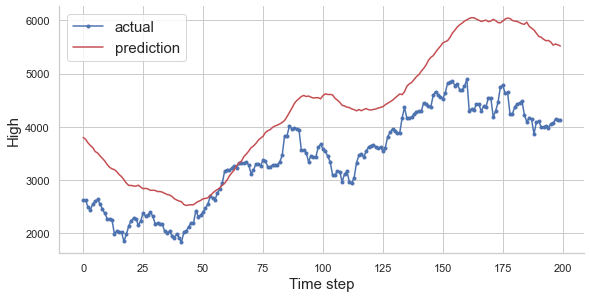

In [24]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('High', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();